# A code example: The distribution order placement

In [7]:
import pandas as pd
import os
import numpy as np
import statsmodels.tsa.api as ts
import matplotlib.pyplot as plt
import seaborn as sns
INTC_LOB   = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]=="k"])
TSLA_LOB   = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]=="k"])
INTC_order = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]!="k"])
TSLA_order = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]!="k"])

In [2]:
def binning(x,y,nbin=10,eq = True):
    step = (np.max(x)-np.min(x))/(nbin)
    X = []
    Y = []
    Yerr = []
    tmpY = []
    start = np.min(x)+step
    if eq:
        for i in range(len(x)):
            while x[i] > start:
                X.append(start-step/2)
                Y.append(np.mean(tmpY))
                #Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpY=[]
                pass
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(start-step/2)
            Y.append(np.mean(tmpY))
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X,Y,Yerr
        pass
    else:
        tmpX = []
        Xerr = []
        for i in range(len(x)):
            while x[i] > start:
                X.append(np.mean(tmpX))
                Y.append(np.mean(tmpY))
                Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpX=[]
                tmpY=[]
                pass
            tmpX.append(x[i])
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(np.mean(tmpX))
            Y.append(np.mean(tmpY))
            Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X, Y, Yerr

In [14]:
def PreProcessing(t,sign,price, sell, buy):
    T = np.zeros(len(t))
    RelPrice = np.zeros(len(t))
    Sign = np.zeros(len(t))
    for i in range(len(t)):
        #if buy
        if sign[i] == 1:
            RelPrice[i] = sell[i] - price[i]
            Sign[i] = 1
            pass
        #if sell
        else:
            RelPrice[i] = price[i] - buy[i]
            Sign[i] = -1
            pass
        pass
    return RelPrice,Sign

In [30]:
RelPrice = []
Sign = []
BestBuy = []
BestSell = []
for i,z in zip(INTC_order,INTC_LOB):
    data = pd.read_csv(i,header=None)[[0,1,4,5]]
    lob = pd.read_csv(z,header=None)[[0,2]]
    data[6] = lob[0]
    data[7] = lob[2]
    use = data[data[1]==1].values
    BestSell.extend(use[:,-2].tolist().copy())
    BestBuy.extend( use[:,-1].tolist().copy())
    a,b = PreProcessing(use[:,0],use[:,3],use[:,2],use[:,4],use[:,5] )
    RelPrice.extend(a.copy())
    Sign.extend(b.copy())
#    break    
    pass

In [31]:
RelPrice = np.array(RelPrice)
Sign = np.array(Sign)
BestBuy = np.array(BestBuy)
BestSell = np.array(BestSell)

acf_buy = ts.acf(RelPrice[Sign==1],nlags=10000)[1:]
t = np.arange(1,10001,1)
acf_sell = ts.acf(RelPrice[Sign!=1],nlags=10000)[1:]


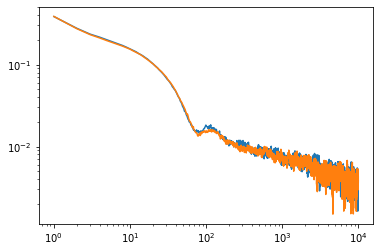

In [20]:
plt.plot(t,acf_buy)
plt.plot(t,acf_sell)
plt.yscale("log")
plt.xscale("log")

In [35]:
series = RelPrice[Sign==1][1:]
price  = BestBuy[Sign==1]
vl_buy = np.abs(np.diff(np.log10(price)))
cov = [np.mean(vl_buy[:-i]*series[i:] ) for  i in range(1,10001,1)]


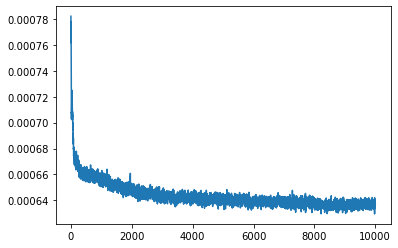

In [36]:
plt.plot(t,cov)
#plt.ylim([0,1])

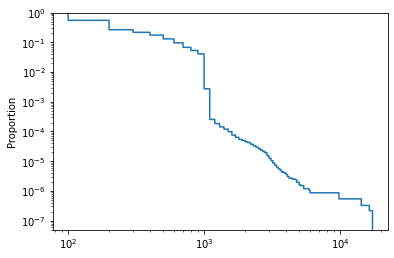

In [32]:
sns.ecdfplot(Sign,complementary=True)
plt.xscale("log")
plt.yscale("log")


In [7]:
Sign = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)#[[0,1,5]]
    lob = pd.read_csv(z,header=None)#[[0,1,5]]
    break
    execution = data[(data[1] == 4) | (data[1] == 5)][[0,5]].values
    a,b = PreProcessing(execution[:,0],execution[:,1])
    Sign.extend(b.copy())
    
    pass


In [5]:
data

,0,1,2,3,4,5
0,34200.006789,5,0,13,2228300,1
1,34200.034290,6,-1,17011,2228700,-1
2,34200.034290,1,5519048,11,2227500,1
3,34200.034290,1,2142274,10,2230000,-1
4,34200.034290,1,2629509,200,2226000,1
...,...,...,...,...,...,...
216706,57599.977910,4,267961846,39,2193100,-1
216707,57599.977910,4,267963915,61,2193100,-1
216708,57599.977975,1,267983787,100,2191900,1
216709,57599.978001,3,267981940,100,2193100,-1


In [52]:
def PreProcessing(t,orderid, record):
    T = np.zeros(len(t))
    dynamics = {i:[] for i in np.unique(orderid)}
    for i in range(len(t)):
        if record[i]==1:
            dynamics[orderid[i]].append(t[i])
            pass
        elif (record[i]==2 ) or (record[i]==3):
            dynamics[orderid[i]].append(t[i])
            #break
            pass
        pass
    result = []
    for i in dynamics.values():
        if len(i)>1:
            result.extend(np.diff(i).tolist())
            pass
        pass
    return result#,dynamics

In [53]:
a= PreProcessing(data[0].values,data[2].values,data[1].values)

In [54]:
DurationTSLA = []
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[[0,1,2]]
    a    = PreProcessing(data[0].values,data[2].values,data[1].values)
    DurationTSLA.extend(a.copy())
    pass
DurationINTC = []
for i,z in zip(INTC_order,INTC_LOB):
    data = pd.read_csv(i,header=None)[[0,1,2]]
    a    = PreProcessing(data[0].values,data[2].values,data[1].values)
    DurationINTC.extend(a.copy())
    pass


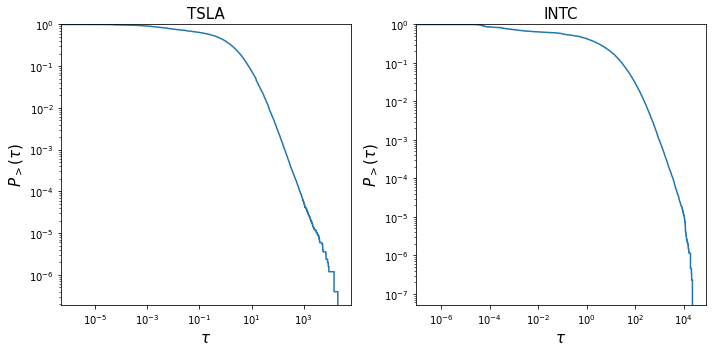

In [56]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

sns.ecdfplot(DurationTSLA,complementary=True,ax=ax1)

sns.ecdfplot(DurationINTC,complementary=True,ax=ax2)

ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.set_title("TSLA",fontsize=15)
ax1.set_xlabel(r"$\tau$",fontsize=15)
ax1.set_ylabel(r"$P_{>}(\tau)$",fontsize=15)

ax2.set_title("INTC",fontsize=15)
ax2.set_xlabel(r"$\tau$",fontsize=15)
ax2.set_ylabel(r"$P_{>}(\tau)$",fontsize=15)
plt.savefig("Duration_CO.png")
plt.savefig("../../../docs/CodeExample/StylizedFacts/Duration_CO.png")


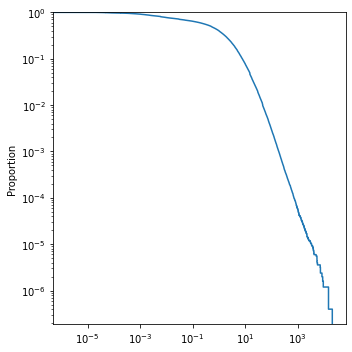

In [57]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),tight_layout=True)
sns.ecdfplot(DurationTSLA,complementary=True,ax=ax1)

ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_xlabel(r"$\tau$",fontsize=15)
ax2.set_ylabel(r"$P_{>}(\tau)$",fontsize=15)

plt.savefig("../../../docs/CodeExample/StylizedFacts/Duration_CO.png")